# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [3]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_torino'
DISTANCE = 20
ROUNDS = 20
OTHER_DATE = '2024-03-23'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_torino with closest execution date 2024-03-23 08:50:28.990762+00:00.


# Get IQ data

In [4]:
SHOTS = int(1e4)
NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]
# NOISE_LIST = None
P_AMBIG = 0.1

IQ_data= simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)

# Simulator

# Decode IQ data

In [5]:
import pymatching
import stim

model = simulator.stim_circ.detector_error_model(decompose_errors=False)
matching = pymatching.Matching.from_detector_error_model(model)

In [6]:
import numpy as np
import cpp_soft_info
from Scratch import load_calibration_memory

# bandwidths = np.linspace(0.05, 0.9, 20)
# bandwidths =[0.6]
bandwidths = np.linspace(0.1, 0.5, 20)
# bandwidths = np.linspace(0.4, 0.7, 1) # Check again!
all_memories = load_calibration_memory(provider, tobecalib_backend=DEVICE, other_date=OTHER_DATE)
kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwidths, relError=1, absError=-1, num_points=51)

Found jobs for backend ibm_torino with closest execution date 2024-03-23 08:50:28.990762+00:00.


In [7]:
for i in range(133):
    print(i, kde_dict[i].bestBandwidth)

0 0.24736842105263157
1 0.3315789473684211
2 0.20526315789473684
3 0.22631578947368422
4 0.31052631578947365
5 0.22631578947368422
6 0.22631578947368422
7 0.24736842105263157
8 0.22631578947368422
9 0.24736842105263157
10 0.26842105263157895
11 0.20526315789473684
12 0.24736842105263157
13 0.1631578947368421
14 0.20526315789473684
15 0.1631578947368421
16 0.22631578947368422
17 0.1842105263157895
18 0.20526315789473684
19 0.26842105263157895
20 0.20526315789473684
21 0.22631578947368422
22 0.20526315789473684
23 0.24736842105263157
24 0.1842105263157895
25 0.14210526315789473
26 0.12105263157894737
27 0.20526315789473684
28 0.14210526315789473
29 0.2894736842105263
30 0.1842105263157895
31 0.3315789473684211
32 0.24736842105263157
33 0.39473684210526316
34 0.20526315789473684
35 0.12105263157894737
36 0.20526315789473684
37 0.22631578947368422
38 0.37368421052631584
39 0.24736842105263157
40 0.22631578947368422
41 0.20526315789473684
42 0.2894736842105263
43 0.24736842105263157
44 0.16

In [50]:
mmr = all_memories[0]['mmr_0']
print(mmr.shape)

(30075,)


# Convertor decoding

In [51]:
from soft_info import inv_qubit_mapping

qubit_mapping = simulator.qubit_mapping
inv_qubit_mapping = inv_qubit_mapping(qubit_mapping)
print(inv_qubit_mapping)

{13: [0, 19, 38, 57, 76, 95, 114, 133, 152, 171, 190, 209, 228, 247, 266, 285, 304, 323, 342, 361], 11: [1, 20, 39, 58, 77, 96, 115, 134, 153, 172, 191, 210, 229, 248, 267, 286, 305, 324, 343, 362], 9: [2, 21, 40, 59, 78, 97, 116, 135, 154, 173, 192, 211, 230, 249, 268, 287, 306, 325, 344, 363], 7: [3, 22, 41, 60, 79, 98, 117, 136, 155, 174, 193, 212, 231, 250, 269, 288, 307, 326, 345, 364], 5: [4, 23, 42, 61, 80, 99, 118, 137, 156, 175, 194, 213, 232, 251, 270, 289, 308, 327, 346, 365], 3: [5, 24, 43, 62, 81, 100, 119, 138, 157, 176, 195, 214, 233, 252, 271, 290, 309, 328, 347, 366], 1: [6, 25, 44, 63, 82, 101, 120, 139, 158, 177, 196, 215, 234, 253, 272, 291, 310, 329, 348, 367], 15: [7, 26, 45, 64, 83, 102, 121, 140, 159, 178, 197, 216, 235, 254, 273, 292, 311, 330, 349, 368], 20: [8, 27, 46, 65, 84, 103, 122, 141, 160, 179, 198, 217, 236, 255, 274, 293, 312, 331, 350, 369], 22: [9, 28, 47, 66, 85, 104, 123, 142, 161, 180, 199, 218, 237, 256, 275, 294, 313, 332, 351, 370], 24: [10, 

In [52]:
pSoft, countMat = cpp_soft_info.iqConvertor(IQ_data, inv_qubit_mapping, kde_dict, 1, -1)

In [53]:
print(f"shape of pSoft: {pSoft.shape}")

# check if there is a nan in the pSoft
if np.isnan(pSoft).any():
    print("There is a nan in the pSoft")

# Print the indices of the nan
print(np.argwhere(np.isnan(pSoft)))


shape of pSoft: (10000, 400)
[]


In [54]:
print(countMat)
if np.isnan(countMat).any():
    print("There is a nan in the countMat")
else:
    print("There is no nan in the countMat")

[[0 0 1 ... 0 0 0]
 [0 1 1 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 1 0 0]]
There is no nan in the countMat


In [55]:
print(f"IQ_data shape: {IQ_data.shape}")
print(f"pSoft shape: {pSoft.shape}")
print(f"countMat shape: {countMat.shape}")

IQ_data shape: (10000, 400)
pSoft shape: (10000, 400)
countMat shape: (10000, 400)


In [56]:
result = cpp_soft_info.decodeConvertorSoft(model, countMat, pSoft, ROUNDS, int(LOGICAL), _RESETS, False)
print(result.num_errors)

27


In [57]:
print(pSoft.shape)
print(f"mean pSoft: {np.mean(pSoft)}, max pSoft: {np.max(pSoft)}, min pSoft: {np.min(pSoft)}")
print(f"unique values: {np.unique(pSoft)}")

print() 

twobitpSoft = cpp_soft_info.quantizeMatrixVectorized(pSoft, 2)
print(twobitpSoft.shape)
print(f"mean 2bpS: {np.mean(twobitpSoft)}, max 2bpS: {np.max(twobitpSoft)}, min 2bpS: {np.min(twobitpSoft)}")
print(f"unique values: {np.unique(twobitpSoft)}")

print()

twobitpSoft_ews = cpp_soft_info.quantizeMatrixEntrywise(pSoft, 2)
print(twobitpSoft_ews.shape)
print(f"mean 2bpS ews: {np.mean(twobitpSoft_ews)}, max 2bpS ews: {np.max(twobitpSoft_ews)}, min 2bpS ews: {np.min(twobitpSoft_ews)}")
print(f"unique values: {np.unique(twobitpSoft_ews)}")

(10000, 400)
mean pSoft: 0.03289522033499805, max pSoft: 0.5, min pSoft: 4.52307841509178e-15
unique values: [4.52307842e-15 4.54107358e-15 4.99207771e-15 ... 4.99996740e-01
 4.99998861e-01 5.00000000e-01]

(10000, 400)
mean 2bpS: 0.018020166666666657, max 2bpS: 0.5, min 2bpS: 0.0
unique values: [0.         0.16666667 0.33333333 0.5       ]

(10000, 400)
mean 2bpS ews: 0.073855171875, max 2bpS ews: 0.5, min 2bpS ews: 0.0625
unique values: [0.0625 0.1875 0.3125 0.4375 0.5   ]


# Quantize the matrix

In [58]:
pSoft_quantized = cpp_soft_info.quantizeMatrixVectorized(pSoft, nBits=20)
# pSoft_quantized = cpp_soft_info.quantizeMatrixEntrywise(pSoft, nBits=20)
# print(pSoft_quantized)

In [59]:
result = cpp_soft_info.decodeConvertorSoft(model, countMat, pSoft_quantized, ROUNDS, int(LOGICAL), _RESETS, False)
print(result.num_errors)

26


In [60]:
from tqdm import tqdm

errs = []
for i in tqdm(range(1, 15, 1)):
    pSoft_quantized = cpp_soft_info.quantizeMatrixVectorized(pSoft, nBits=i)
    # pSoft_quantized = cpp_soft_info.quantizeMatrixEntrywise(pSoft, nBits=i)
    result = cpp_soft_info.decodeConvertorSoft(model, countMat, pSoft_quantized, ROUNDS, int(LOGICAL), _RESETS, False)
    errs.append(result.num_errors)

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:14<00:00,  1.01s/it]


Text(0.5, 1.0, 'ibm_torino - 2024-03-23')

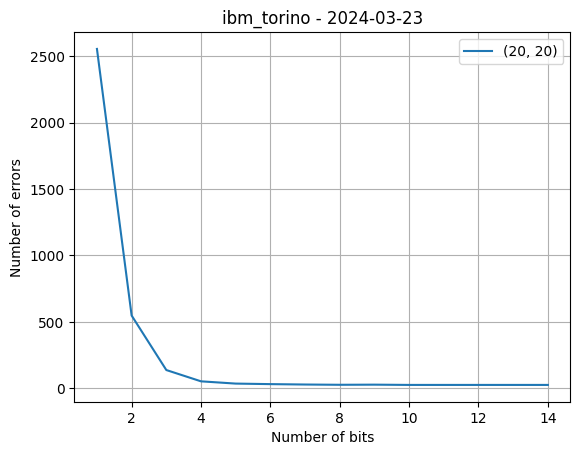

In [61]:
import matplotlib.pyplot as plt

plt.plot(range(1, 15, 1), errs, label=f"({DISTANCE}, {ROUNDS})")
plt.xlabel("Number of bits")
plt.ylabel("Number of errors")
plt.legend()
plt.grid()
plt.title(f"{DEVICE} - {OTHER_DATE}")


# Subset decoding

In [62]:
distances = range(3, DISTANCE+1, 4)
print(list(distances))

nBits_ls = range(1, 20, 1)
print(list(nBits_ls))

[3, 7, 11, 15, 19]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [63]:
from tqdm import tqdm
from soft_info import generate_subsets_with_center, get_cols_to_keep, RepetitionCodeStimCircuit

for D_NEW in distances:
    if D_NEW != 15:
        continue

    subsets = generate_subsets_with_center(DISTANCE, D_NEW)

    for subset in subsets:

        cols_to_keep = get_cols_to_keep(subset, ROUNDS, DISTANCE)
        pSoft_sub = pSoft[:, cols_to_keep]
        countMat_sub = countMat[:, cols_to_keep]

        # circuit = stim.Circuit.generated("repetition_code:memory",
        #                         distance=D_NEW,
        #                         rounds=ROUNDS,
        #                         after_clifford_depolarization=NOISE_LIST[0], #two-qubit-fidelity,
        #                         after_reset_flip_probability=NOISE_LIST[1], #reset error,
        #                         before_measure_flip_probability=NOISE_LIST[2], #measurement error,
        #                         before_round_data_depolarization=NOISE_LIST[3]) #idle error)
        # model = circuit.detector_error_model(decompose_errors=False)

        noise_list = [NOISE_LIST[0], 0, NOISE_LIST[3], NOISE_LIST[3], NOISE_LIST[2], NOISE_LIST[2]/2, NOISE_LIST[2]/2]
        # [twog_err, sglg_err, t1_err, t2_err, readout_err, hard_err, soft_err]
        subsampling = (D_NEW != DISTANCE)
        code = RepetitionCodeStimCircuit(D_NEW, ROUNDS, xbasis=False, resets=_RESETS, 
                                        noise_list=noise_list, subsampling=subsampling)
        model = code.circuits[str(LOGICAL)].detector_error_model(decompose_errors=False)  


        errs_per_nBits = []
        result = cpp_soft_info.decodeConvertorSoft(model, countMat_sub, pSoft_sub,
                                                                                ROUNDS, int(LOGICAL), _RESETS, False)
        errs_per_nBits.append(result.num_errors)
        for nBits in tqdm(nBits_ls):
            pSoft_trunc = cpp_soft_info.quantizeMatrixVectorized(pSoft_sub, nBits)
            # pSoft_trunc = cpp_soft_info.quantizeMatrixEntrywise(pSoft_sub, nBits)
            result = cpp_soft_info.decodeConvertorSoft(model, countMat_sub, pSoft_trunc,
                                                                                ROUNDS, int(LOGICAL), _RESETS, False)
            errs_per_nBits.append(result.num_errors)
        print(errs_per_nBits)
    
    

# print(errs_per_nBits)

100%|██████████| 19/19 [00:13<00:00,  1.44it/s]


[135, 3046, 1015, 378, 209, 143, 136, 142, 134, 136, 134, 133, 134, 133, 133, 133, 133, 133, 133, 133]


100%|██████████| 19/19 [00:14<00:00,  1.33it/s]

[84, 2920, 882, 317, 156, 98, 96, 89, 88, 89, 88, 87, 86, 86, 86, 86, 86, 86, 86, 86]


# Using cpp kde

In [14]:
_DETAILED = False

matching = pymatching.Matching.from_detector_error_model(model)
result = cpp_soft_info.decode_IQ_fast(model, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=_DETAILED, nb_intervals=-1)

print("num_errors IQ:", result.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)

num_errors IQ: 34 out of 10000 shots for _RESETS = False


In [15]:
_DETAILED = False

relError = 1
absError = -1

# relError = 1
# absError = 10

result_kde = cpp_soft_info.decode_IQ_kde(model, IQ_data, ROUNDS, int(LOGICAL), _RESETS, 
                                         simulator.qubit_mapping, kde_dict, _DETAILED, relError=relError, absError=absError,
                                         nb_intervals=-1)

print("num_errors KDE:", result_kde.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)

num_errors KDE: 26 out of 10000 shots for _RESETS = False


In [ ]:
p_meas = -1
# p_meas = 7e-2 

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(model, IQ_data[:],
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

print("num_errors informed:", result_informed.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
         
# takes 1s

num_errors informed: 0 out of 100 shots for _RESETS = False
num_errors informed EXTREME: 8 out of 100 shots for _RESETS = False


# Plot the results

In [ ]:
print("\nIQ:", result.indices, "\nkde:", sorted(result_kde.indices), "\nInformed", result_informed.indices)


IQ: [] 
kde: [] 
Flat: [] 
Informed []

IQ EXTREME: [] 
kde EXTREME: [] 
Flat EXTREME: [] 
Informed EXTREME []


----- First True decoding -----


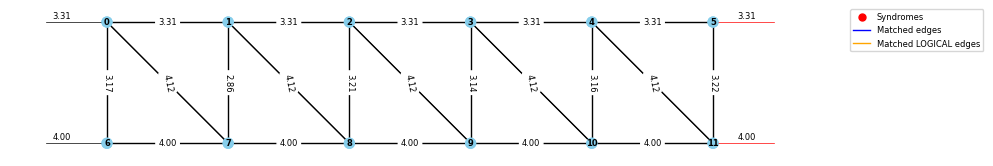

-----Second True decoding-----


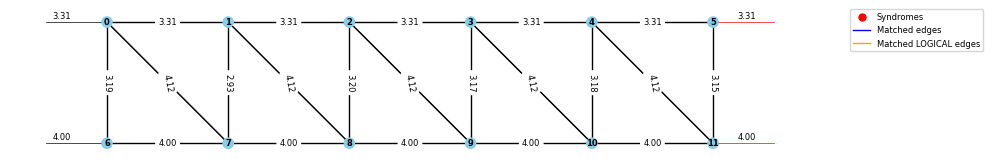

-----Third True decoding-----


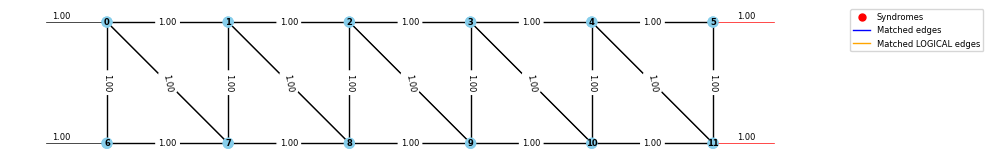

In [ ]:
from soft_info import draw_matching_graph


index = 10

fig_size = (4, 13)
fig_size = (8, 8)
scale_factor = 0.5

to_be_result = result_kde
details = to_be_result.error_details[index]
print(f"----- First {bool(not (index in to_be_result.indices))} decoding -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result
details = to_be_result.error_details[index]
print(f"-----Second {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print(f"-----Third {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [ ]:
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print("indices that are in informed but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print("indices that are in IQ but not in informed with len:", len(iq_not_in_informed))
print(iq_not_in_informed)

print()

iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print("indices that are in IQ but not in flat with len:", len(iq_not_in_flat))
print(iq_not_in_flat)
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print("indices that are in flat but not in IQ with len:", len(flat_not_in_iq))
print(flat_not_in_iq)

print()

iq_not_in_kde = sorted(set(result.indices) - set(result_kde.indices))
print("indices that are in IQ but not in kde with len:", len(iq_not_in_kde))
print(iq_not_in_kde)
kde_not_in_iq = sorted(set(result_kde.indices) - set(result.indices))
print("indices that are in kde but not in IQ with len:", len(kde_not_in_iq))
print(kde_not_in_iq)

indices that are in informed but not in IQ with len: 0
[]
indices that are in IQ but not in informed with len: 0
[]

indices that are in IQ but not in flat with len: 0
[]
indices that are in flat but not in IQ with len: 0
[]

indices that are in IQ but not in kde with len: 0
[]
indices that are in kde but not in IQ with len: 0
[]


# Analyse specific shots

{'0010000 001000': 1}


100%|██████████| 25/25 [00:00<00:00, 519097.03it/s]

mean time edge weight: 3.2142805258433023

[(1, 7), (0, -1)]
-----IQ-----


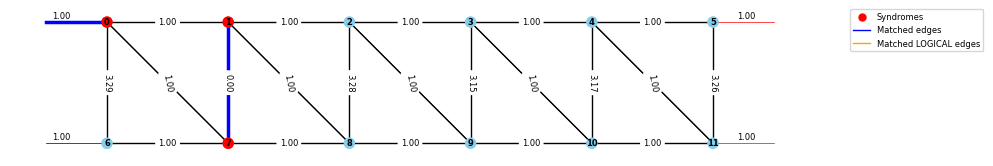

In [ ]:
from tqdm import tqdm

index = 83
IQ_data_new = IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = True)

print(cpp_soft_info.get_counts(IQ_data_new, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print()
print(details.matched_edges)

print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)